<a href="https://colab.research.google.com/github/Gsdvl/chess-evaluator/blob/test-colab/chess-evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Grupo:
    - Débora Noemy de Alcântara Valentim
    - Gabriel Soares Vasconcelos Lira
    - Lucas Loureiro Albuquerque da Silva Eloi

In [1]:
import pandas as pd
import numpy as np

## Análise exploratória dos dados ##
 - Os dados foram obtidos no Kaggle, contém informações sobre a avaliação de posições de tabuleiros de xadrez: https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations

Primeiramente, para começarmos a fazer uma análise exploratória para decidir os objetivos, devemos entender a estrutura dos dados com os quais estamos lidando.
Os dados estão divididos em 3 tabelas.
 - chessData contém informações sobre estados de tabuleiros na notação FEN, e a avaliação dele em centipawns (1/100 do valor de um peão)
 - random_evals contém diversos tabuleiros montados aleatoriamente a partir de diversas jogadas, e a avaliação dele em centipawns
 - tactic_evals é similar ao chessData, mas além disso, possui o melhor movimento possível naquele tabuleiro decidido com auxilio da ferramenta Linchess
#### Entender a notação FEN ####
 - A notação FEN é composta por 8 linhas, cada uma contendo peças, em maiusculo para brancas e minusculo para pretas, tendo um número de 1-8 indicando quantas casas vazias entre uma peça e outra. Após isso temos letras para ver a notação sobre de quem é o turno, possibilidade de roques e en passants
#### Centipawns #####
 - Outro fator comum entre todos os datasets é a avaliação do stockfish em centipawns, onde vão existir duas variações, as com # que indicam mate naquela posição, e as sem mate que indicam apenas a avaliação geral do tabuleiro
#### Move ####
 - A base de dados tactic_evals contém uma coluna Move, que contém informações da melhor jogada do Linchess, contendo a cordenada atual e a cordenada futura



In [2]:
# Upload do kaggle.json
from google.colab import files
files.upload()

# Configuração do Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Instalação do cliente do Kaggle
!pip install kaggle

Saving kaggle.json to kaggle.json


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ronakbadhe/chess-evaluations")

print("Path to dataset files:", path)

100%|██████████| 200M/200M [00:02<00:00, 75.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ronakbadhe/chess-evaluations/versions/5


In [4]:
chessData = pd.read_csv('/root/.cache/kagglehub/datasets/ronakbadhe/chess-evaluations/versions/5/chessData.csv')
random_evals = pd.read_csv('/root/.cache/kagglehub/datasets/ronakbadhe/chess-evaluations/versions/5/random_evals.csv')
tactic_evals = pd.read_csv('/root/.cache/kagglehub/datasets/ronakbadhe/chess-evaluations/versions/5/tactic_evals.csv')

In [5]:
print(chessData.head())
print(random_evals.head())
print(tactic_evals.head())

                                                 FEN Evaluation
0  rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...        -10
1  rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...        +56
2  rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...         -9
3  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...        +52
4  rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...        -26
                                                 FEN Evaluation
0  rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1...       -459
1  rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK...       -125
2  rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBN...       +198
3  rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB...       -155
4  rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBN...       +209
                                                 FEN Evaluation  Move
0  r2qkbr1/pb1nn3/1ppp3p/8/3P1p2/2PB1N1P/PPQN1PP1...        #+2  d3g6
1  r2qkb2/pb1nn3/1ppp2rp/8/3P1p2/2P2N1P/PPQN1PP1/...        #+1  c2g6
2  r2qkbr1/pb1nn3/1ppp

In [6]:
data_mates = chessData['Evaluation'][chessData['Evaluation'].str.contains('#', na=False)]
data_mates

,Evaluation
59,#+6
60,#+6
61,#+4
62,#+3
1440,#-19
...,...
12957453,#+8
12957454,#+9
12957551,#-6
12957552,#-5


In [7]:
# Averiguando o comprimento das jogadas, é possível perceber que certos movimentos possuem 5 letras, para representar peões promovidos
dif_len_moves = tactic_evals[tactic_evals['Move'].str.len() != 4]
dif_len_moves

,FEN,Evaluation,Move
62,r2qkb2/pb1nn3/1ppp2Qp/8/3P1p2/2P2N1P/PP1N1PP1/...,#+0,NaN
63,8/7p/5Rp1/2p1pkP1/7P/P4PK1/1r6/3q4 b - - 7 46,#+0,NaN
64,2R2k2/6b1/3N1r1p/r2b2p1/2p5/3p4/P4PPP/2B1R1K1 ...,#+0,NaN
65,k1Q5/pp2p3/2p5/4B3/7q/4N3/PP6/2K5 b - - 0 40,#+0,NaN
66,4R1k1/2q2pp1/5b1p/p4B2/1pN5/1P5P/P4PP1/6K1 b -...,#+0,NaN
...,...,...,...
2627644,1r4r1/5ppk/p3p3/2q1PP2/2pp4/P5NQ/1P4PP/1b5K b ...,#+0,NaN
2627820,r1b1k2r/pp1p1pPp/4p3/8/8/4qP2/PPPKNb1P/R1BQ1B1...,#-0,NaN
2627826,5Nkr/pbp2pp1/1p2p3/1B6/P2P3p/2P4n/2PQ1P1P/R4RK...,#-0,NaN
2627915,1k5r/p7/Qp2p3/R1ppNp2/3P1n2/2P3q1/2P5/5RK1 w -...,#-0,NaN


## Pré-processamento dos dados ##

Formato de um código FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

Para utilizar esses dados em um modelo de IA, precisamos fazer algums tratamentos para transformar eles em um input

#### Pré-processamento código FEN ####

- Tokenização: Podemos análisar o código mais facilmente tokenizando o valor para os valores presentes em suas linhas

- Remoção de dados irrelevantes: Para nosso objetivo, que não envolve validação de jogadas, as informações após o tabuleiro não são úteis

- Converter números para 0: Transformar um número naquela quantidade de 0's é importante para representar as casas vazias

- Conversão para matriz: Utilizando a pontuação de sarrat para converter peças em números e transformar o código em uma matriz 8x8

#### Pré-processamento evaluation ####

 - Cheques: Para transformar esses dados em algo mais legível, os cheques serão tratados para existir uma colunas apenas com valores boleanos, se aquele tabuleiro esta com mate ou não, mantendo a coluna de evaluation separada

#### Pré-processamento jogada (tactic_evals) ####

- Tokenização: Similarmente a como fizemos com a notação FEN, para as jogadas, iremos separar os valores em tokens por letra

- Tratar peça extra: Jogadas que envolvem promoções de peões, possuem um algarismo a mais denotando a peça para a qual ele foi promovido, portanto, irei realizar a substituição dessa peça, pela pontuação de sarrat equivalente, e acrecentar um valor 0 ao final dos tokens que não possuem ela para manter as entradas no mesmo formato sem ter perca de informação

- Conversão tokens: Para simplificar o entendimento pelo modelo, não seria um problema para a notação, substituir o valor das letras, por seu equivalente numérico, que na prática é a mesma coisa nesse contexto



In [8]:
#Reduzindo o tamanho dos dados para ser gentil com meu notebook
chessData = chessData[0:500000]
tactic_evals = tactic_evals[0:500]

In [9]:
tactic_evals = tactic_evals.dropna()

In [10]:
sarrat = {
    'P':1,
    'N':3.1,
    'B':3.3,
    'R':5,
    'Q':7.9,
    'K':2.2,
    'p':-1,
    'n':-3.1,
    'b':-3.3,
    'r':-5,
    'q':-7.9,
    'k':-2.2,
    '0': 0
}
letters = ['a','b','c','d','e','f','g','h']

In [11]:
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [12]:
# Operações para tratar boards
def separate_board(board):
    return board['FEN'].apply(lambda x: x.replace('/', ' ').split()).tolist()

def remove_extras(board):
    return [row[:8] for row in board]

def num_to_zeros(board):
    return [
        [re.sub(r'[1-9]', lambda x: '0' * int(x.group()), cell) if isinstance(cell, str) else cell for cell in row]
        for row in board
    ]

def fen_to_matrix(board):
    if isinstance(board, pd.DataFrame):
        board = board.iloc[:, 0].tolist()

    matrix = []
    for row in board:
        row_a = []
        for piece in row:
            if piece in sarrat:
                row_a.append(sarrat[piece])
            else:
                row_a.append(0)
        matrix.append(row_a)
    return matrix

def fen_in_column(board_column):
    return [fen_to_matrix(row) for row in board_column]


#Operações para tratar movimentos

def separate_move(move):
    return [list(i) for i in move]


def normalize_size(move):
    norm_moves = []
    for row in move:
        if len(row) == 4:
            row.append('0')
        norm_moves.append(row)
    return norm_moves



def coords_to_numbers(moves):
    num_moves = []
    for cord in moves:
        num_move = []
        for i in cord:
            if i in letters:
                num_move.append(letters.index(i))
            elif i.isdigit():
                num_move.append(int(i) - 1)
        num_moves.append(num_move)
    return num_moves


#Operações para evaluation

def mate_column(evaluation):
    return ('#' in evaluation)

In [13]:
pipeline_transform_fen = Pipeline([
    ('Separate board into lines', FunctionTransformer(separate_board)),
    ('Remove no-board info', FunctionTransformer(remove_extras)),
    ('Convert num to zeros', FunctionTransformer(num_to_zeros)),
    ('Convert fen notation to matrix', FunctionTransformer(fen_in_column))
])

In [14]:
pipeline_transform_move = Pipeline([
    ('Separate move', FunctionTransformer(separate_move)),
    ('Normalize size', FunctionTransformer(normalize_size)),
    ('Convert coords to numbers', FunctionTransformer(coords_to_numbers))
])

In [15]:
cleared_chess_data = chessData.copy()

print(cleared_chess_data['FEN'].head())
cleared_chess_data['FEN'] = pipeline_transform_fen.fit_transform(cleared_chess_data[['FEN']])

cleared_chess_data['MATE'] = mate_column(cleared_chess_data['Evaluation'])
cleared_chess_data.head()

0    rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...
1    rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...
2    rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...
3    rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...
4    rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...
Name: FEN, dtype: object


,FEN,Evaluation,MATE
0,"[[-5, -3.1, -3.3, -7.9, -2.2, -3.3, -3.1, -5],...",-10,False
1,"[[-5, -3.1, -3.3, -7.9, -2.2, -3.3, -3.1, -5],...",+56,False
2,"[[-5, -3.1, -3.3, -7.9, -2.2, -3.3, -3.1, -5],...",-9,False
3,"[[-5, -3.1, -3.3, -7.9, -2.2, -3.3, -3.1, -5],...",+52,False
4,"[[-5, -3.1, -3.3, -7.9, -2.2, -3.3, -3.1, -5],...",-26,False


In [16]:
cleared_tactic_evals = tactic_evals.copy()


cleared_tactic_evals['Move'] = pipeline_transform_move.fit_transform(cleared_tactic_evals['Move'])
cleared_tactic_evals['FEN'] = pipeline_transform_fen.fit_transform(cleared_tactic_evals[['FEN']])
cleared_tactic_evals['MATE'] = mate_column(cleared_tactic_evals['Evaluation'])


In [17]:
cleared_tactic_evals.head()

,FEN,Evaluation,Move,MATE
0,"[[-5, 0, 0, -7.9, -2.2, -3.3, -5, 0], [-1, -3....",#+2,"[3, 2, 6, 5, -1]",False
1,"[[-5, 0, 0, -7.9, -2.2, -3.3, 0, 0], [-1, -3.3...",#+1,"[2, 1, 6, 5, -1]",False
2,"[[-5, 0, 0, -7.9, -2.2, -3.3, -5, 0], [-1, -3....",#+1,"[6, 7, 6, 5, -1]",False
3,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",#+1,"[0, 5, 5, 5, -1]",False
4,"[[0, 0, 0, 0, 0, 0, -2.2, 0], [-1, -1, 0, 0, 0...",+408,"[7, 2, 6, 3, -1]",False


In [18]:
#from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Concatenate, Input, Conv2D
#from tensorflow.keras.models import Model
#sfrom tensorflow.keras.callbacks import EarlyStopping

In [19]:
from sklearn.model_selection import train_test_split

# Suponha que cleared_chess_data já está processado
X = np.stack(cleared_chess_data['FEN'].to_numpy())  # Converte as matrizes para um array 3D
y = cleared_chess_data['MATE'].astype(int).to_numpy()  # Converte o alvo para 0/1

# Normalizar os dados
X = X / np.max(np.abs(X))

# Adicionar uma dimensão de canal
X = X[..., np.newaxis]

# Dividir os dados em treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Formato do conjunto de treinamento: {X_train.shape}")
print(f"Formato do conjunto de validação: {X_val.shape}")

Formato do conjunto de treinamento: (400000, 8, 8, 1)
Formato do conjunto de validação: (100000, 8, 8, 1)


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(8, 8, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Saída binária
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 6, 6, 32)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,881 (73.75 KB)

 Trainable params: 18,881 (73.75 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9991 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 2.8143e-11
Epoch 2/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 1.0000 - loss: 1.5408e-08 - val_accuracy: 1.0000 - val_loss: 1.3718e-17
Epoch 3/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 1.0000 - loss: 8.1752e-11 - val_accuracy: 1.0000 - val_loss: 5.1975e-20
Epoch 4/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 1.0000 - loss: 1.0709e-11 - val_accuracy: 1.0000 - val_loss: 2.5974e-20
Epoch 5/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 1.0000 - loss: 1.3843e-11 - val_accuracy: 1.0000 - val_loss: 7.1495e-21
Epoch 6/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 1.0000 - loss: 3.6272e-12 - val_accuracy: 1.0000 - val_loss: 4.9341e-21
Epoch 7/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 1.0000 - loss: 9.9274e-12 - val_accuracy: 1.0000 - val_loss: 1.7365e-21
Epoch 8/20
12500/

In [22]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Loss na validação: {val_loss}")
print(f"Acurácia na validação: {val_accuracy}")


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 5.6188e-23
Loss na validação: 5.815484486555472e-23
Acurácia na validação: 1.0


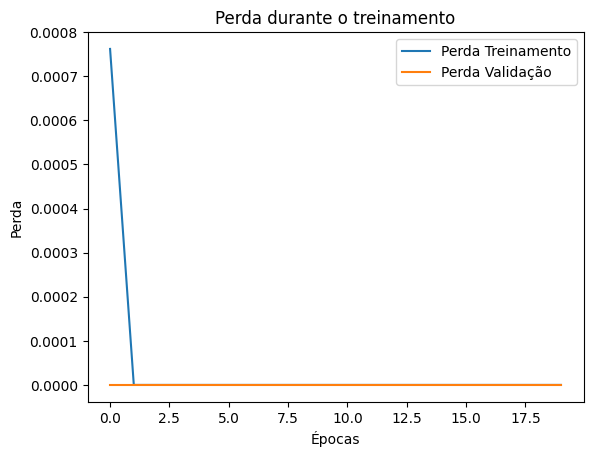

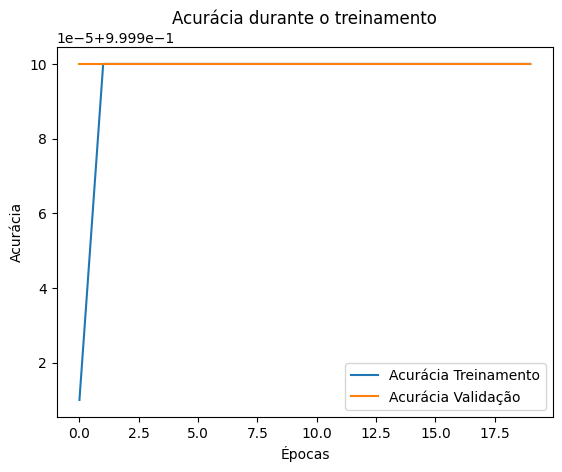

In [23]:
import matplotlib.pyplot as plt

# Plotar perda
plt.plot(history.history['loss'], label='Perda Treinamento')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.legend()
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.show()

# Plotar acurácia
plt.plot(history.history['accuracy'], label='Acurácia Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.legend()
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.show()
